In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = False # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
command_file_name = "../data/western_north_america/basic_command.json"
command_file_name = "../data/japan/japan_new481_shannon_command.json"

command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

# Get elastic operators and TDE smoothing operators

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)
celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

# Calculate non-elastic operators

In [5]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Plot input data

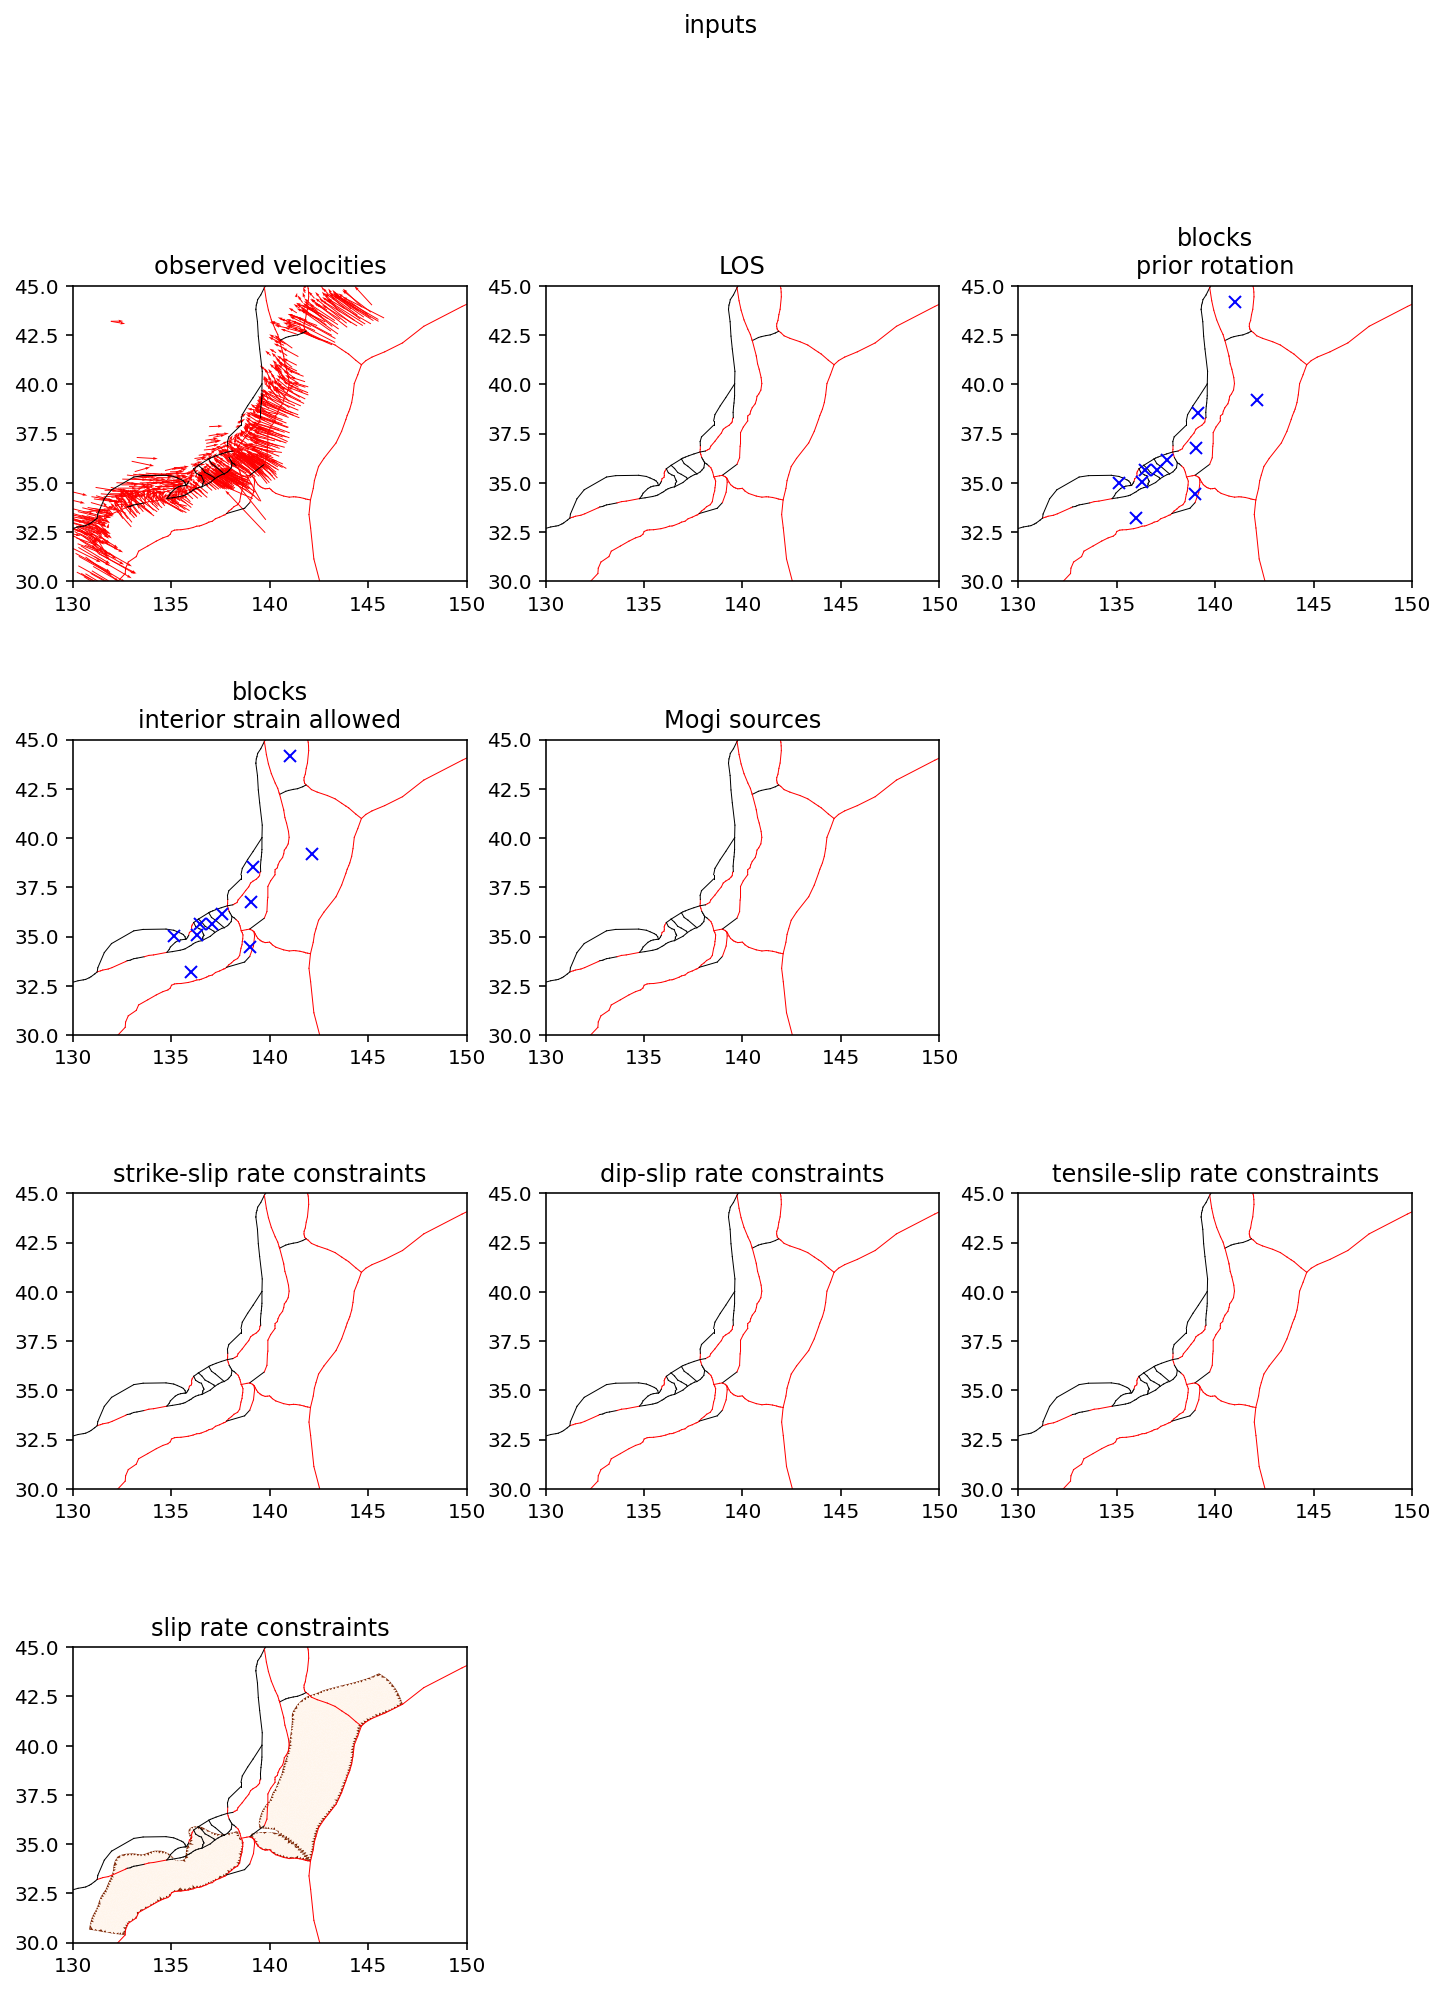

In [10]:
celeri.plot_input_summary(segment, station, block, meshes, mogi, sar, lon_range=(130.0, 150.0), lat_range=(30.0, 45.0), quiver_scale=1e2)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Block model with block rotations, fully locked segments and partially locked subduction zone using the full tde_matrix and smoothing matrix

In [7]:
# TODO: What should this conversion be?
DEG_PER_MYR_TO_RAD_PER_YR = np.deg2rad(1) / 1e6
DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e6

# Create dictionary to store indices and sizes for operator building
index = addict.Dict()
index.n_stations = assembly.data.n_stations
index.vertical_velocities = np.arange(2, 3 * index.n_stations, 3)
index.n_blocks = len(block)
index.n_block_constraints = assembly.data.n_block_constraints
index.station_row_keep_index = celeri.get_keep_index_12(3 * len(station))
index.start_station_row = 0
index.end_station_row = 2 * len(station)
index.start_block_col = 0
index.end_block_col = 3 * len(block)
index.start_block_constraints_row = index.end_station_row
index.end_block_constraints_row = index.start_block_constraints_row + 3 * index.n_block_constraints
index.n_slip_rate_constraints = assembly.data.slip_rate_constraints.size
index.start_slip_rate_constraints_row = index.end_block_constraints_row
index.end_slip_rate_constraints_row = index.start_slip_rate_constraints_row + index.n_slip_rate_constraints

index.n_tde_total = 0
index.n_tde_constraints_total = 0
for i in range(len(meshes)):
    index.n_tde[i] = meshes[i].n_tde
    index.n_tde_total += index.n_tde[i]
    index.n_tde_constraints[i] = meshes[i].n_tde_constraints
    index.n_tde_constraints_total += index.n_tde_constraints[i]
    if i == 0:
        index.start_tde_col[i] = index.end_block_col
        index.end_tde_col[i] = index.start_tde_col[i] + 2 * index.n_tde[i]
        index.start_tde_smoothing_row[i] = index.end_slip_rate_constraints_row
        index.end_tde_smoothing_row[i] = index.start_tde_smoothing_row[i] + 2 * index.n_tde[i]
        index.start_tde_constraint_row[i] = index.end_tde_smoothing_row[i]
        index.end_tde_constraint_row[i] = index.start_tde_constraint_row[i] + index.n_tde_constraints[i]
    else:
        index.start_tde_col[i] = index.end_tde_col[i - 1]
        index.end_tde_col[i] = index.start_tde_col[i] + 2 * index.n_tde[i]
        index.start_tde_smoothing_row[i] = index.end_tde_smoothing_row[i - 1]
        index.end_tde_smoothing_row[i] = index.start_tde_smoothing_row[i] + 2 * index.n_tde[i]
        index.start_tde_constraint_row[i] = index.end_tde_smoothing_row[i - 1]
        index.end_tde_constraint_row[i] = index.start_tde_constraint_row[i] + index.n_tde_constraints[i]

# Initialize data vector
estimation = addict.Dict()
estimation.data_vector = np.zeros(2 * index.n_stations + 3 * index.n_block_constraints + index.n_slip_rate_constraints + 2 * index.n_tde_total + index.n_tde_constraints_total)

# Add GPS stations to data vector
estimation.data_vector[index.start_station_row:index.end_station_row] = celeri.interleave2(assembly.data.east_vel, assembly.data.north_vel)

# Add block motion constraints to data vector
estimation.data_vector[index.start_block_constraints_row:index.end_block_constraints_row] = DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints

# Add slip rate constraints to data vector
estimation.data_vector[index.start_slip_rate_constraints_row:index.end_slip_rate_constraints_row] = assembly.data.slip_rate_constraints

# Initialize and build weighting matrix
estimation.weighting_vector = np.ones(2 * index.n_stations + 3 * index.n_block_constraints + index.n_slip_rate_constraints + 2 * index.n_tde_total + index.n_tde_constraints_total)
estimation.weighting_vector[index.start_station_row:index.end_station_row] = celeri.interleave2(1 / (station.east_sig ** 2), 1 / (station.north_sig ** 2))
estimation.weighting_vector[index.start_block_constraints_row:index.end_block_constraints_row] = 1.0
estimation.weighting_vector[index.start_slip_rate_constraints_row:index.end_slip_rate_constraints_row] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

# Initialize linear operator
estimation.operator = np.zeros((2 * index.n_stations + 3 * index.n_block_constraints + index.n_slip_rate_constraints + 2 * index.n_tde_total + index.n_tde_constraints_total,
                                3 * index.n_blocks + 2 * index.n_tde_total))

# Insert block rotations and elastic velocities from fully locked segments
operators.rotation_to_slip_rate_to_okada_to_velocities = operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
estimation.operator[index.start_station_row:index.end_station_row, index.start_block_col:index.end_block_col] = operators.rotation_to_velocities[index.station_row_keep_index, :] - operators.rotation_to_slip_rate_to_okada_to_velocities[index.station_row_keep_index, :]

# Insert block motion constraints
estimation.operator[index.start_block_constraints_row:index.end_block_constraints_row, index.start_block_col:index.end_block_col] = operators.block_motion_constraints

# Insert slip rate constraints
estimation.operator[index.start_slip_rate_constraints_row:index.end_slip_rate_constraints_row, index.start_block_col:index.end_block_col] = operators.slip_rate_constraints

# Insert TDE to velocity matrix
for i in range(len(meshes)):
    # Insert TDE to velocity matrix
    tde_keep_row_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[0])
    tde_keep_col_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[1])
    estimation.operator[index.start_station_row:index.end_station_row, index.start_tde_col[i]:index.end_tde_col[i]] = -operators.tde_to_velocities[i][tde_keep_row_index, :][:, tde_keep_col_index]

    # Insert TDE smoothing matrix
    smoothing_keep_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[1])
    estimation.operator[index.start_tde_smoothing_row[i]:index.end_tde_smoothing_row[i], index.start_tde_col[i]:index.end_tde_col[i]] = operators.smoothing_matrix[i].toarray()[smoothing_keep_index, :][:, smoothing_keep_index]

    # Insert smoothing weight into weighting vector
    estimation.weighting_vector[index.start_tde_smoothing_row[i]:index.end_tde_smoothing_row[i]] = meshes[i].smoothing_weight * np.ones(2 * index.n_tde[i])

    # Insert TDE slip rate constraints into estimation operator
    estimation.operator[index.start_tde_constraint_row[i]:index.end_tde_constraint_row[i], index.start_tde_col[i]:index.end_tde_col[i]] = operators.tde_slip_rate_constraints[i]


# Solve the overdetermined linear system using only a weighting vector rather than matrix
estimation.state_covariance_matrix = np.linalg.inv(estimation.operator.T * estimation.weighting_vector @ estimation.operator)
estimation.state_vector = estimation.state_covariance_matrix @ estimation.operator.T * estimation.weighting_vector @ estimation.data_vector

# celeri.post_process_estimation(estimation, operators, station, index)

In [8]:
celeri.post_process_estimation(estimation, operators, station, index)

# Plot model summary - Some crazy TDEs

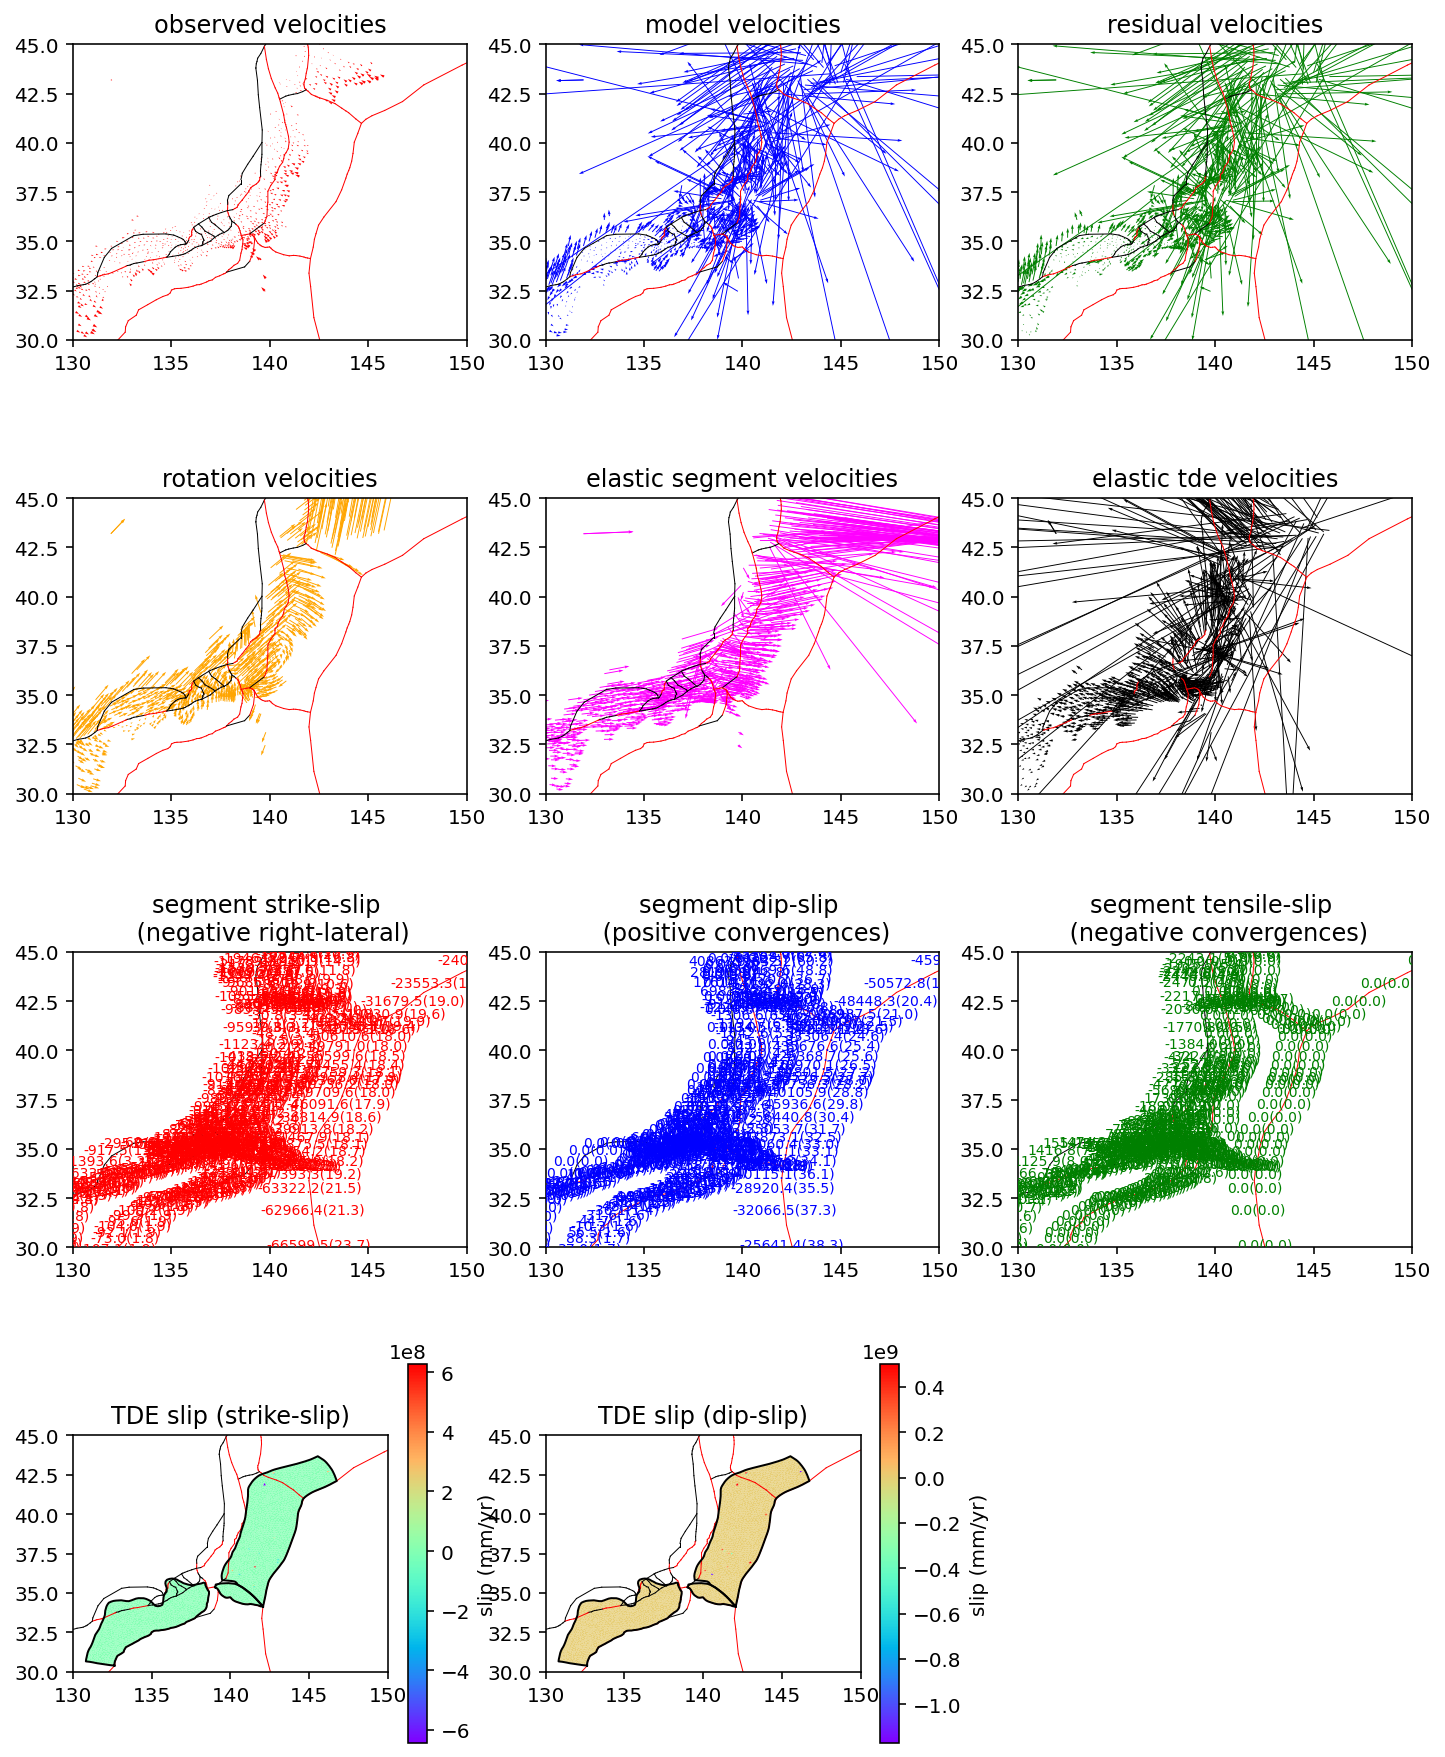

In [27]:
# celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(130.0, 150.0), lat_range=(30.0, 45.0), quiver_scale=1e3)
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(140.0, 145.0), lat_range=(40.0, 42.5), quiver_scale=1e3)

# Plot the estimated TDE slip rates (some of them???)

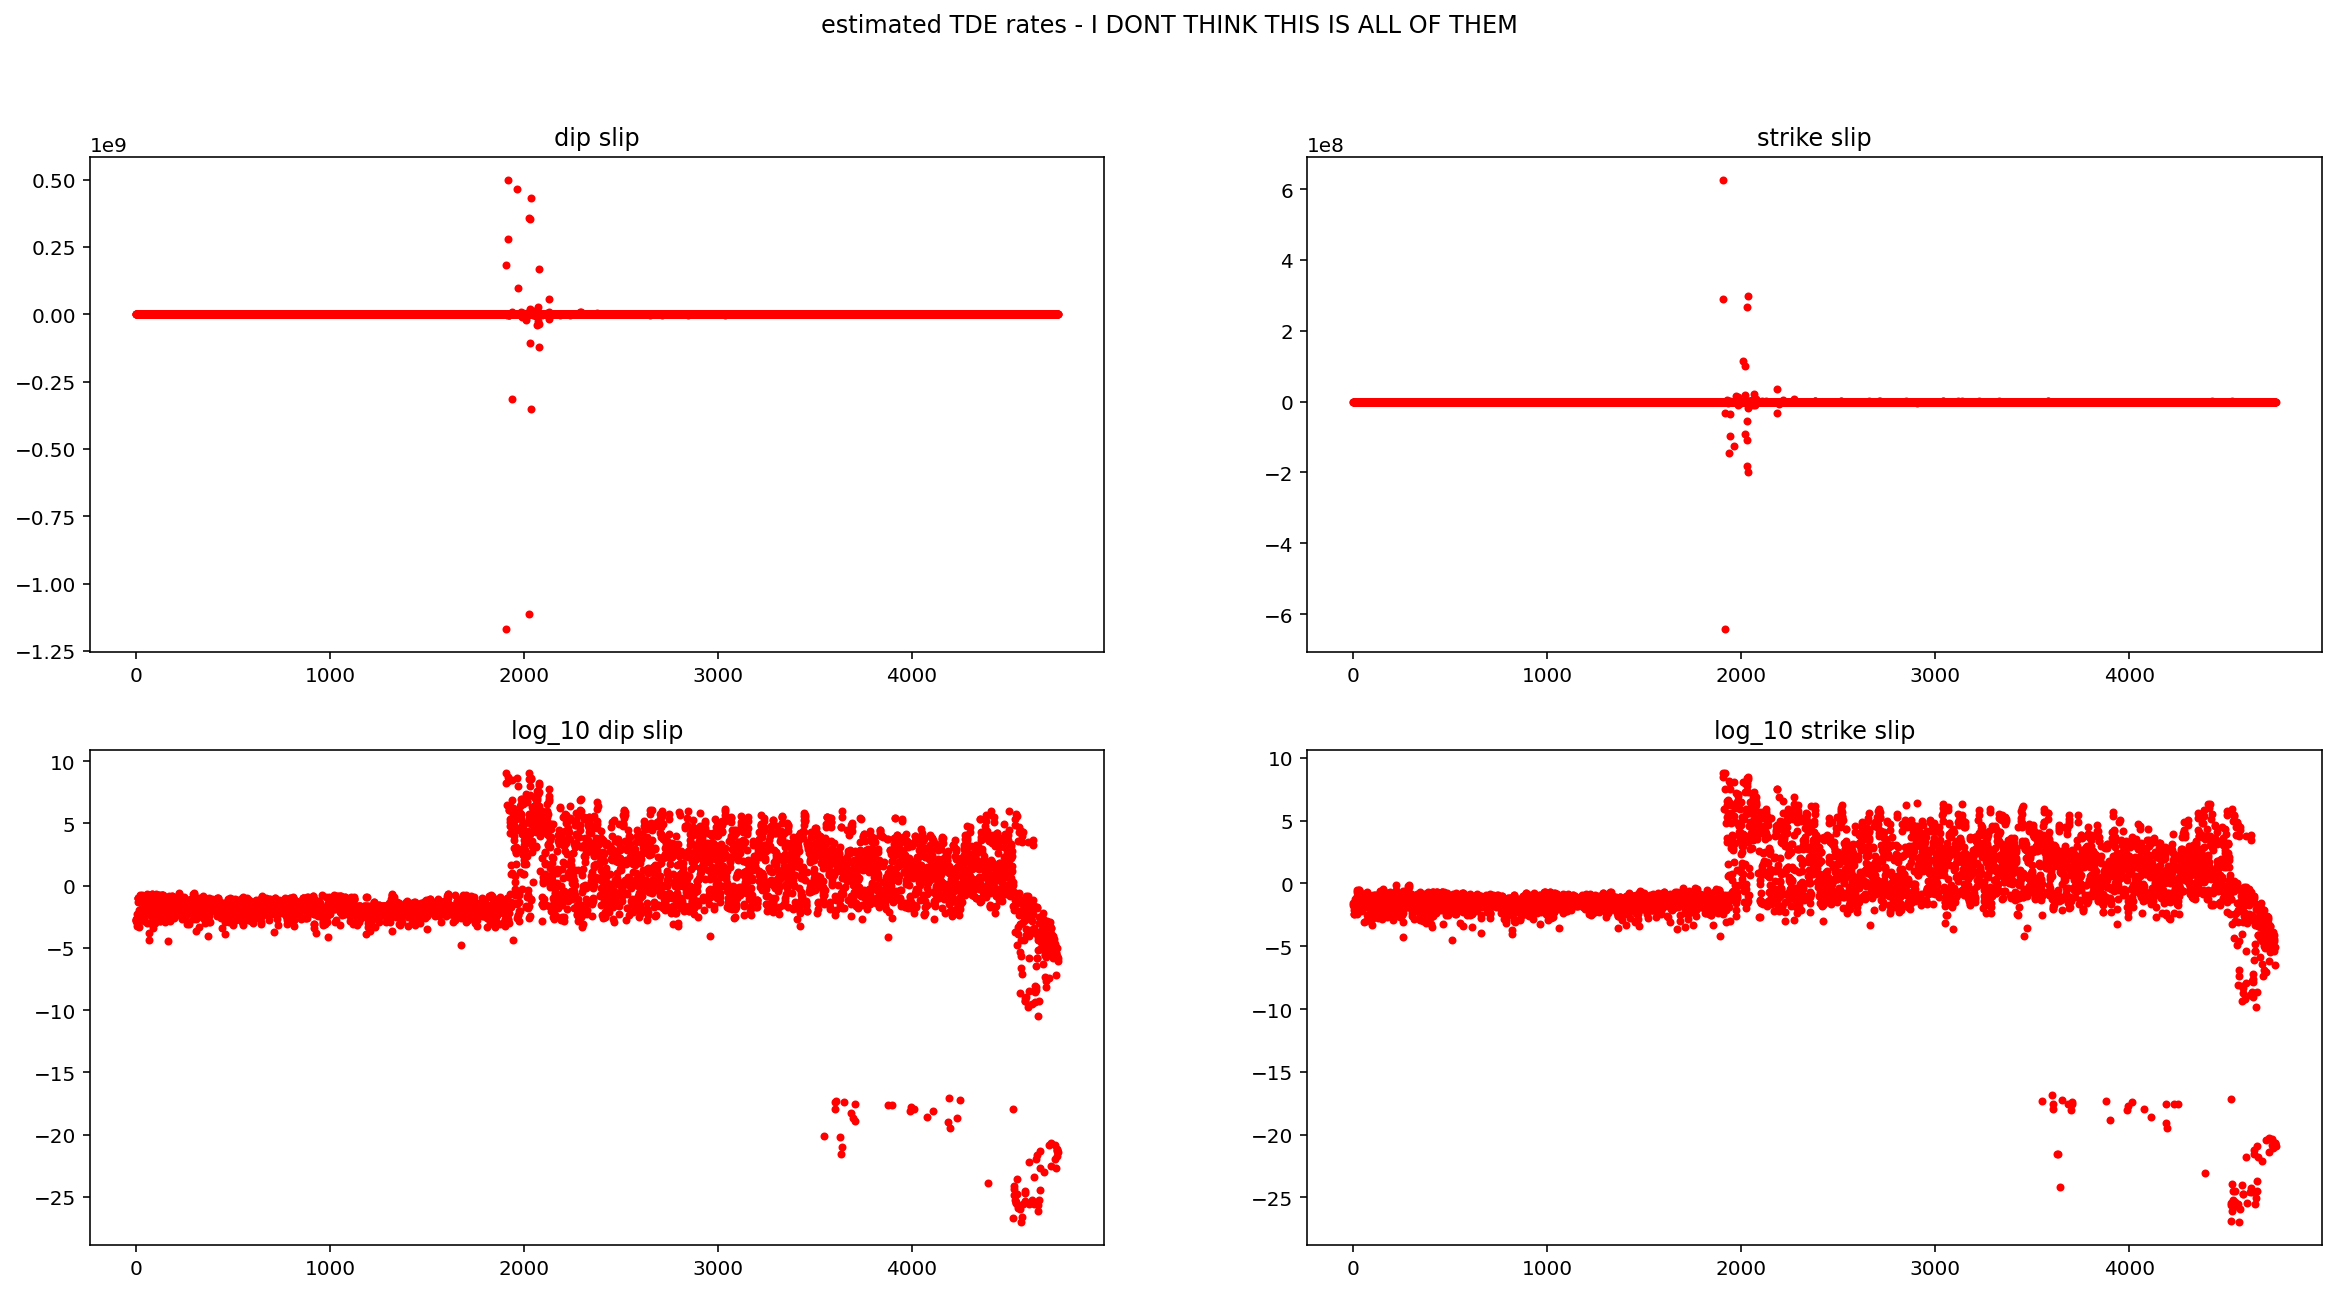

In [58]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(estimation.tde_dip_slip_rates, 'r.')
plt.title("dip slip")
plt.subplot(2, 2, 2)
plt.plot(estimation.tde_strike_slip_rates, 'r.')
plt.title("strike slip")

plt.subplot(2, 2, 3)
plt.plot(np.log10(np.abs(estimation.tde_dip_slip_rates)), 'r.')
plt.title("log_10 dip slip")
plt.subplot(2, 2, 4)
plt.plot(np.log10(np.abs(estimation.tde_strike_slip_rates)), 'r.')
plt.title("log_10 strike slip")

plt.suptitle("estimated TDE rates - I DONT THINK THIS IS ALL OF THEM")

plt.show()


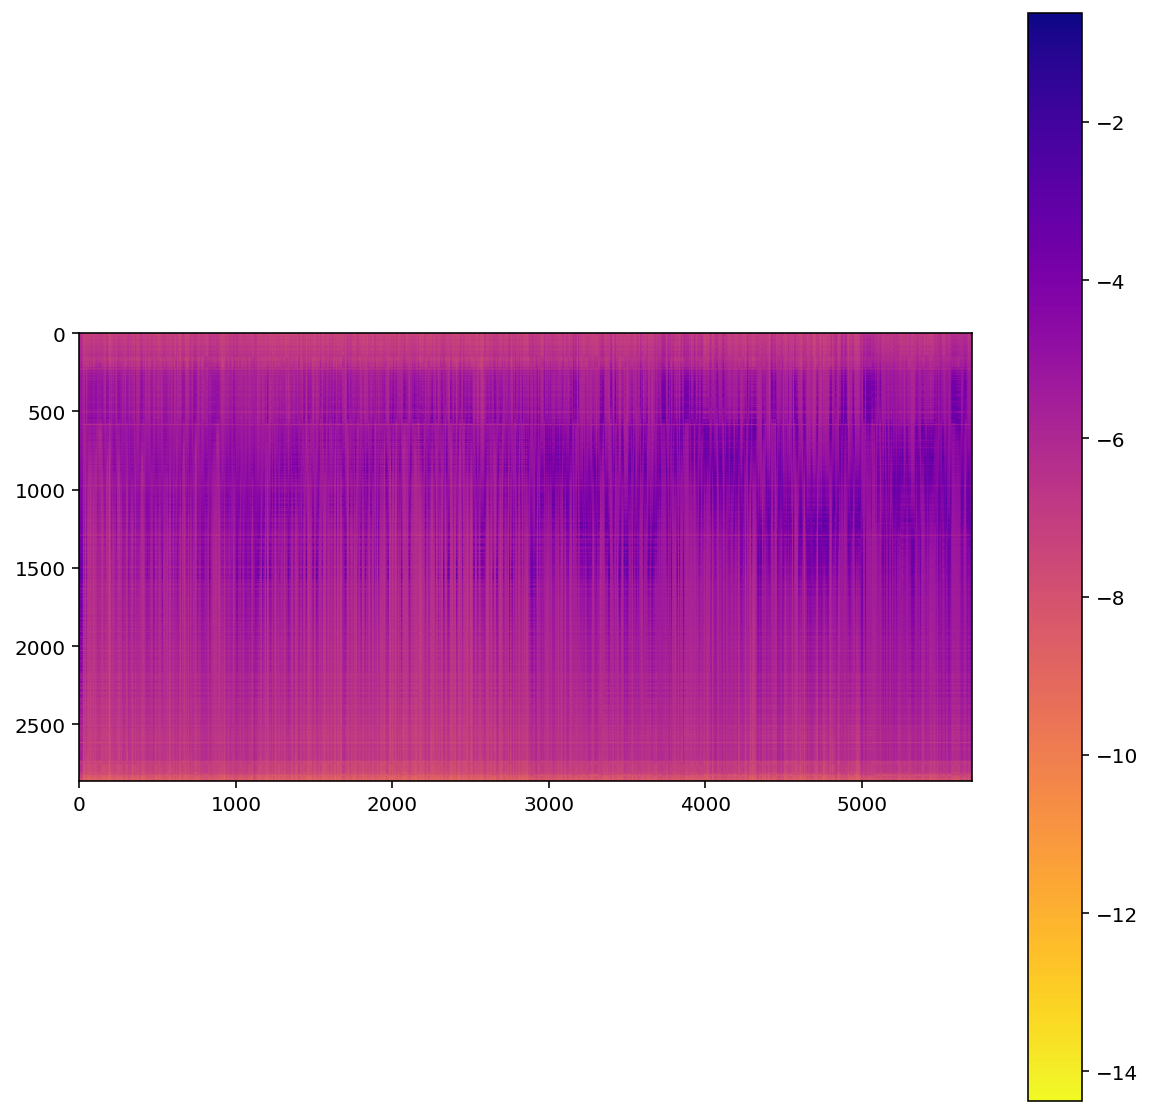

In [56]:
celeri.plot_matrix_abs_log(operators.tde_to_velocities[0])

# Two reallly different estimates of the number of TDEs!!!

In [66]:
meshes[0].n_tde + meshes[1].n_tde + meshes[2].n_tde

4754

In [69]:
operators.tde_to_velocities[0].shape[1] + operators.tde_to_velocities[1].shape[1] + operators.tde_to_velocities[2].shape[1]

14262